✔ ↪ ▢


# Variational Auto Encoder
        ↪ Auto Encoder에 확률적 요소를 추가한 생성 모델.
        AE의 latent space가 single vector를 갖는 반면, VAE는 가우시안 확률 분포로 나타남.

#### ▢ VAE의 목적
        ↪ latent variable(z)의 분포로부터 만들어진 데이터(x)를 구하는 것
        == decoder( pθ(x|z) ) 를 구하는 것

#### ▢ VAE pseudocode
        loss_function{
            recon_loss = batch_size * MSE(input, decoder_output)
            kl_loss = -0.5 * sum(1 + z_logvar - square(z_mean) - exp(z_logvar))
            total_loss = recon_loss + kl_loss
        }

        train_function{
            input = sample_batch_data()
            z_mean, z_logvar = encoder(input)
            noise = sample_noise()
            z = z_mean + noise * exp(0.5*z_logvar)
            decoder_output = decoder(z)
            loss = loss_function(input, decoder_output, z_mean, z_logvar)
            loss.backward()
        }

#### ▢ Terms
        x : 데이터
        z : latent variable
        θ,Φ : 파라미터(p, q) (pdf를 딥러닝 모델로 표현하는 값)
        p : 데이터의 확률분포
        q : 모델이 학습한 확률분포
        pθ(x|z) : latent variable(z)의 분포로부터 만들어진 데이터(x), decoder
        pθ(z|x) : 데이터(x)의 분포로부터 만들어진 latent variable(z)
        학습 시, intractable하기 때문에 qΦ(z|x) (encoder)로 근사

#### ▢ Estimation
        1. 목적은 decoder(pθ(x|z)) 를 구하는 것
            ▢ pθ(x|z) = pθ(z|x) * pθ(x) / pθ(z)
            ▢ pθ(z|x)를 직접 구할 수 없음

        2. KL Divergence를 이용하여, encoder(qΦ(z|x))를 pθ(z|x)에 근사
            ▢ pθ(x|z) ≒ qΦ(z|x) * pθ(x) / pθ(z)
            ▢ decoder ≒ encoder * pθ(x) / z의 확률분포
            ▢ pθ(x)만 알아내면 pθ(x|z)를 구할 수 있음

        3. ELBO(variational lower bound)로부터 log pθ(x)를 근사
            ▢ log pθ(x) ≥ EqΦ(z|x)[logpθ(xi|z)] -KL(qΦ(z|xi)||pθ(z)) + KL(qΦ(z|xi)||pθ(z|xi))
            ▢ KL(qΦ(z|xi)||pθ(z|xi))는 직접 구할 수 없으나, KL Divergence는 항상 0보다 크거나 같으므로 무시
            ▢ log pθ(x) ≥ EqΦ(z|x)[logpθ(xi|z)] -KL(qΦ(z|xi)||pθ(z)) = ELBO
            ▢ ELBO를 maximize 하는 Φ값을 찾으면 근사값을 통해 pθ(x|z)를 구할 수 있음

        4. Optimization
            ▢ 딥러닝에서는 loss를 minimize하는 방향으로 학습하므로, likelyhood에 -를 붙여 최소화하도록 함
            ▢ total loss = reconstruction error + regularization error

            (1) reconstruction error
                ↪ -EqΦ(z|x)[logpθ(xi|z)]를 최소화

                    ▢ 적분이 intractable하므로 Monte-carlo technique으로 근사
                    ▢ Monte-carlo technique : 분포에서 많은 수의 샘플을 취해 평균을 취하면 전체 분포의 기대값과 근사
                    ▢ 그러나 많은 수의 샘플을 취하는 것은 학습 속도를 크게 늦추므로 한번의 샘플링을 대표값으로 사용
                    ▢ input(x)과 output(x^)의 차이를 최소화(L2Loss, MSELoss)

            (2) regularization error
                ↪ KL(qΦ(z|x) | pθ(z))를 최소화

                    ▢ qΦ(z|x) : 데이터(x)로부터 encoder를 거쳐 만들어진 z의 확률분포
                    ▢ pθ(z) : 가우시안 분포를 따르도록 설정한 z의 확률분포
                    ▢ KL divergence를 최소화(두 분포 사이의 차이를 최소화)
                    ▢ regularization error == -0.5 * sum(1 + z_logvar - square(z_mean) - exp(z_logvar))

#### ▢ reparameterization trick
        ↪ latent space에서 샘플링 과정을 미분 가능한 형태로 바꾸는 방법

            (1) encoder(qΦ(z|x))는 x를 입력으로 받아 z의 분포를 출력하므로,
            학습 시 back propagation을 하기 위해서 qΦ(z)가 Φ로 미분 가능해야 함

            (2) 그러나 z로부터의 샘플링은 무작위성을 가지므로 미분 가능한 작업이 아님
            
            (3) noise variable ϵ와 미분 가능한 변환함수 gΦ(ϵ,x)를 사용하여 해결
            (qΦ(z|x)로부터 직접 샘플링하지 않고, 무작위성을 ϵ에 부여)
            
            (4) z = mean + ϵ*exp(0.5*logvar)라는 식을 사용하여 parameter(mean, logvar)에 대해 미분이 가능해짐


코드 참조 : https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [ ]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import datetime
from tqdm import tqdm
import glob
import imageio
import PIL

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# 학습 데이터 셋 MNIST 불러오기

transforms_ = transforms.Compose([
    transforms.Resize(28), # 이미지 크기를 28*28 조절
    transforms.ToTensor(), # 이미지를 tensor type으로 변환
    transforms.Normalize([0.5], [0.5]) # 이미지 정규화. 픽셀 값 범위 -1 ~ 1, 평균 0.5, 표준편차 0.5
])

train_dataset = datasets.FashionMNIST(root="./dataset", train=True, download=True, transform=transforms_)
test_dataset = datasets.FashionMNIST(root="./dataset", train=False, download=True, transform=transforms_)

In [ ]:
def preprocess_images(images) :
    images = images.reshape((images.shape[0], 1, 28, 28)) / 255.
    return images.type(torch.float32)

torch.Size([1, 1, 28, 28])


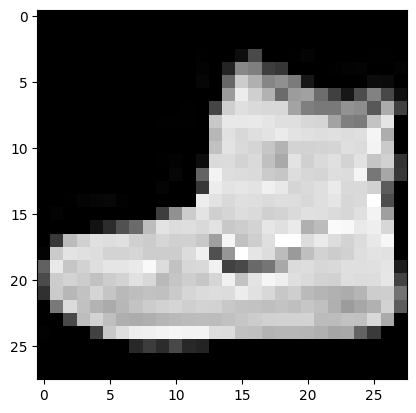

In [ ]:
train_images = preprocess_images(ex)
print(train_images.shape)
plt.imshow(train_images[0, 0, :, :], cmap='gray')

In [ ]:
pre_train_dataset = preprocess_images(train_dataset.data)
pre_test_dataset = preprocess_images(test_dataset.data)

In [ ]:
train_loader = torch.utils.data.DataLoader(pre_train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(pre_test_dataset, batch_size=128, shuffle=False, drop_last=True)

In [ ]:
ex = next(iter(test_loader))

In [ ]:
class GatedSkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        # z : 0 ~ 1 사이의 값
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)


class Encoder(nn.Module) :
    def __init__(self, latent_dim) :
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # Input Size: (batch_size, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=(2,2)),  # Output Size: (batch_size, 32, 14, 14)
            nn.LeakyReLU(0.2),
            # Input Size: (batch_size, 32, 14, 14)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=(2,2)),  # Output Size: (batch_size, 64, 7, 7)
            nn.LeakyReLU(0.2),
            # Output Size: (batch_size, 64, 7, 7)
            )

        self.mean = nn.Linear(64*7*7, self.latent_dim)
        self.log_var = nn.Linear(64*7*7, self.latent_dim)

    def forward(self, x) :
        encoded = self.encoder(x).view(x.size(0), -1)
        mean = self.mean(encoded)
        log_var = self.log_var(encoded)
        return mean, log_var

class Decoder(nn.Module) :
    def __init__(self, latent_dim) :
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            # Input Size: (batch_size, latent_dim)
            nn.Linear(latent_dim, 64*7*7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (64, 7, 7)),
            # Input Size: (batch_size, 64, 7, 7)
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=(2,2)),
            nn.LeakyReLU(0.2),
            # Input Size: (batch_size, 32, 14, 14)
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=(2,2)),
            # Output Size: (batch_size, 1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, z) :
        x_hat = self.decoder(z)
        return x_hat

class VAE(nn.Module) :
    def __init__(self, latent_dim) :
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.latent_dim)

    def reparameterize(self, mean, log_var) :
        eps = torch.randn(mean.size(0), self.latent_dim).to(device)
        z = eps * torch.exp(log_var * 0.5) + mean
        return z

    def vae_loss(self, x, mean, log_var, z, x_hat) :
        recon_criterion = nn.BCELoss(reduction='sum')
        recon_loss = recon_criterion(x_hat, x)

        kl_loss = 0.5 * torch.sum(torch.square(mean) + torch.exp(log_var) - log_var -1)
        return recon_loss, kl_loss

    def forward(self, x) :
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)

        recon_loss, kl_loss = self.vae_loss(x, mean, log_var, z, x_hat)
        return x_hat, recon_loss, kl_loss

In [ ]:
num_epochs = 10
lr = 1e-3
latent_dim = 2

model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [ ]:
def generated_images(preds) :
    preds = preds[:25, :, :, :].detach().numpy()
    for i in range(preds.shape[0]) :
        plt.subplot(5, 5, i+1)
        plt.imshow(preds[i, 0, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig(f'image at epoch {epoch}.png')
    plt.show()

 epoch 1  /  10  [train_loss : 41660.8032] [recon_loss : 40771.0338] [kl_loss : 889.7694945396521]


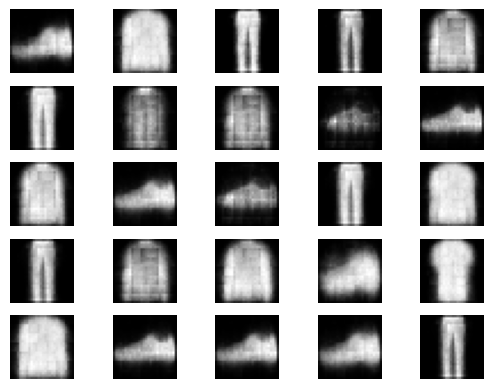


 epoch 2  /  10  [train_loss : 36418.5643] [recon_loss : 35595.1019] [kl_loss : 823.4622163691072]


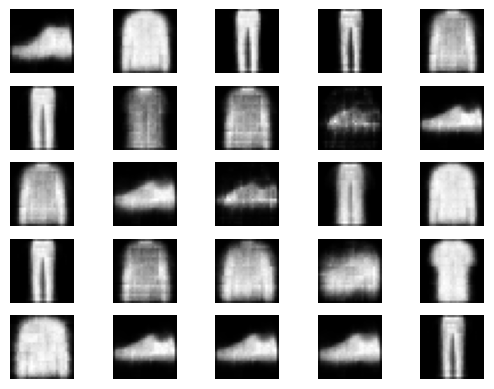


 epoch 3  /  10  [train_loss : 35823.0457] [recon_loss : 35015.2058] [kl_loss : 807.8398565308661]


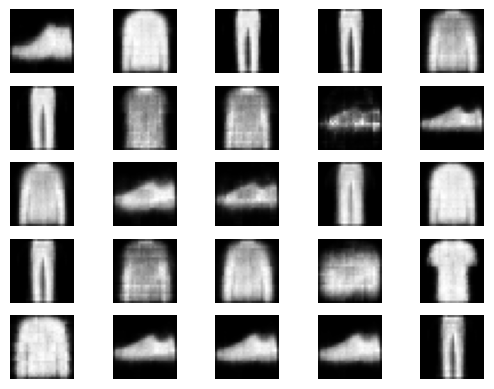


 epoch 4  /  10  [train_loss : 35510.7000] [recon_loss : 34704.4442] [kl_loss : 806.25587893755]


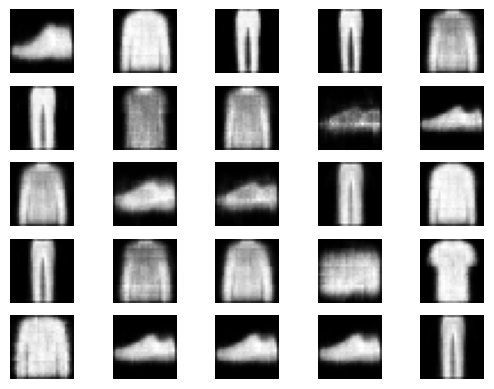


 epoch 5  /  10  [train_loss : 35303.7000] [recon_loss : 34502.1132] [kl_loss : 801.5868668515458]


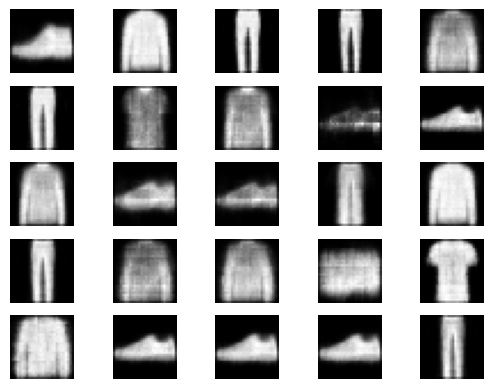


 epoch 6  /  10  [train_loss : 35165.1717] [recon_loss : 34364.8726] [kl_loss : 800.2991691654564]


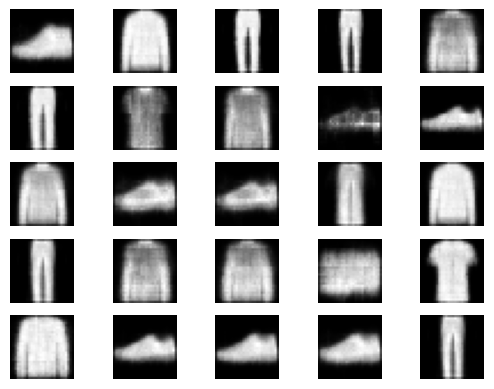


 epoch 7  /  10  [train_loss : 35048.9403] [recon_loss : 34249.5993] [kl_loss : 799.3411094469902]


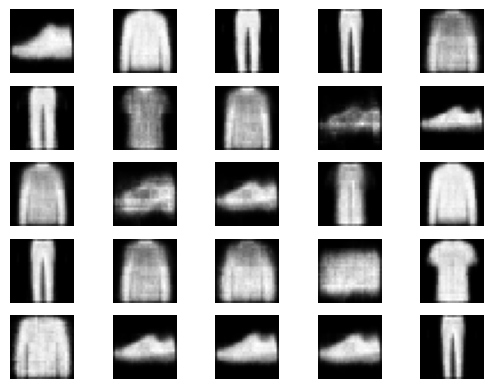


 epoch 8  /  10  [train_loss : 34954.9023] [recon_loss : 34156.6260] [kl_loss : 798.2762985881577]


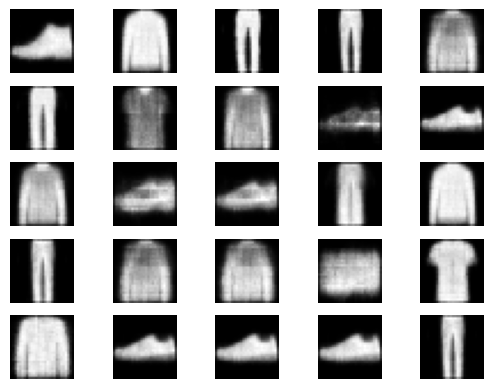


 epoch 9  /  10  [train_loss : 34878.7743] [recon_loss : 34080.0702] [kl_loss : 798.7041449913612]


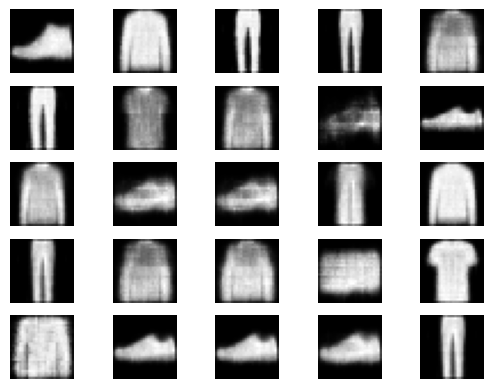


 epoch 10 /  10  [train_loss : 34812.8344] [recon_loss : 34017.6166] [kl_loss : 795.2177240094568]


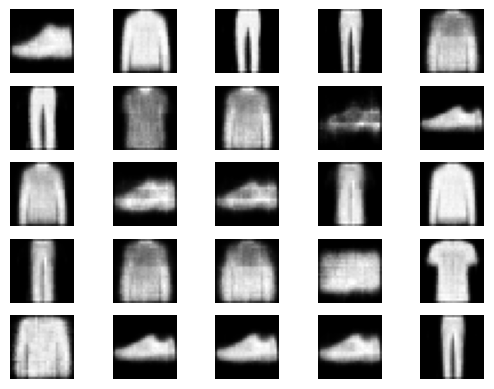

In [ ]:
model.train()
for epoch in range(1, num_epochs+1) :
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    for batch in train_loader :
        x = batch.to(device)
        x_hat, recon_loss, kl_loss = model(x)
        train_loss = recon_loss + kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

    epoch_train_loss /= len(train_loader)
    epoch_recon_loss /= len(train_loader)
    epoch_kl_loss /= len(train_loader)

    if epoch % 1 == 0 :
        print(f'{"epoch":>6} {epoch:<2} / {num_epochs:>3}  {"[train_loss :":>12} {epoch_train_loss:.4f}] {"[recon_loss :":>12} {epoch_recon_loss:.4f}] {"[kl_loss :":>8} {epoch_kl_loss}]')
        ex_hat, _, _ = model(ex)
        generated_images(ex_hat)
        print()


In [ ]:
recon_x, _, _ = model(ex)

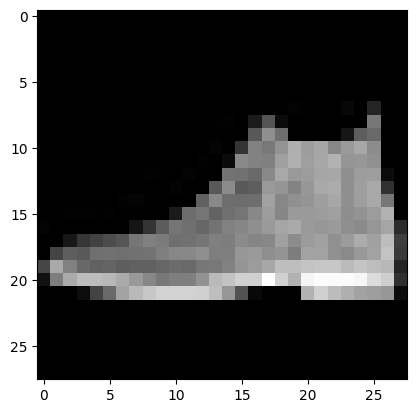

In [ ]:
fig = plt.figure()
plt.imshow(ex[0][0].cpu().numpy(), cmap='gray')

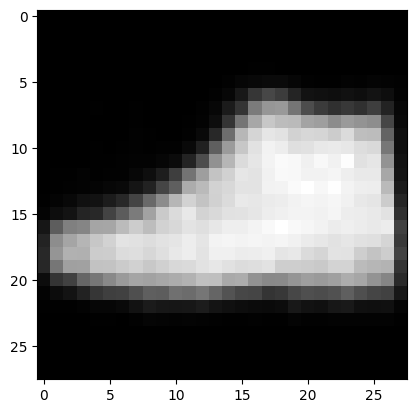

In [ ]:
fig = plt.figure()
plt.imshow(recon_x[0][0].detach().numpy(), cmap='gray')

In [ ]:
def display_image(epoch_no) :
    return PIL.Image.open(f'image at epoch {epoch_no}.png')

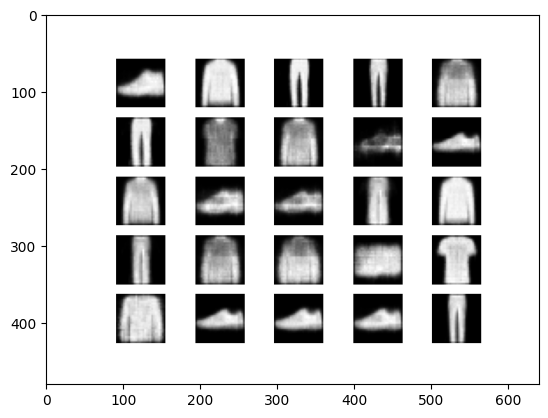

In [ ]:
plt.imshow(display_image(num_epochs))

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer :
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    for filename in filenames :
        image = imageio.imread(filename)
        writer.append_data(image)

<ipython-input-30-47e7fefd7af9>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


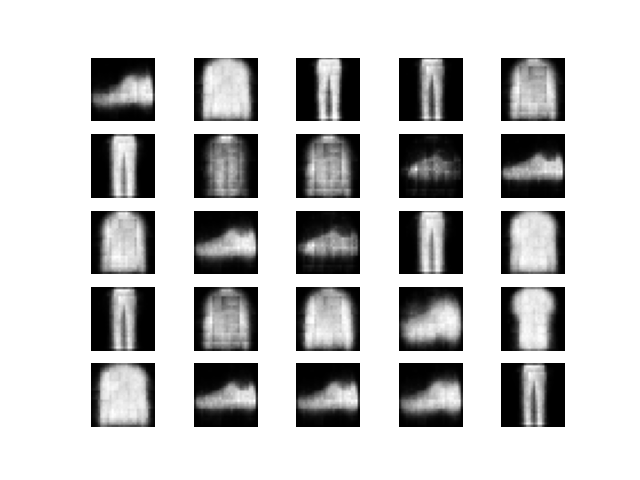

In [ ]:
from IPython.display import Image, display
display(Image(filename="./cvae.gif"))

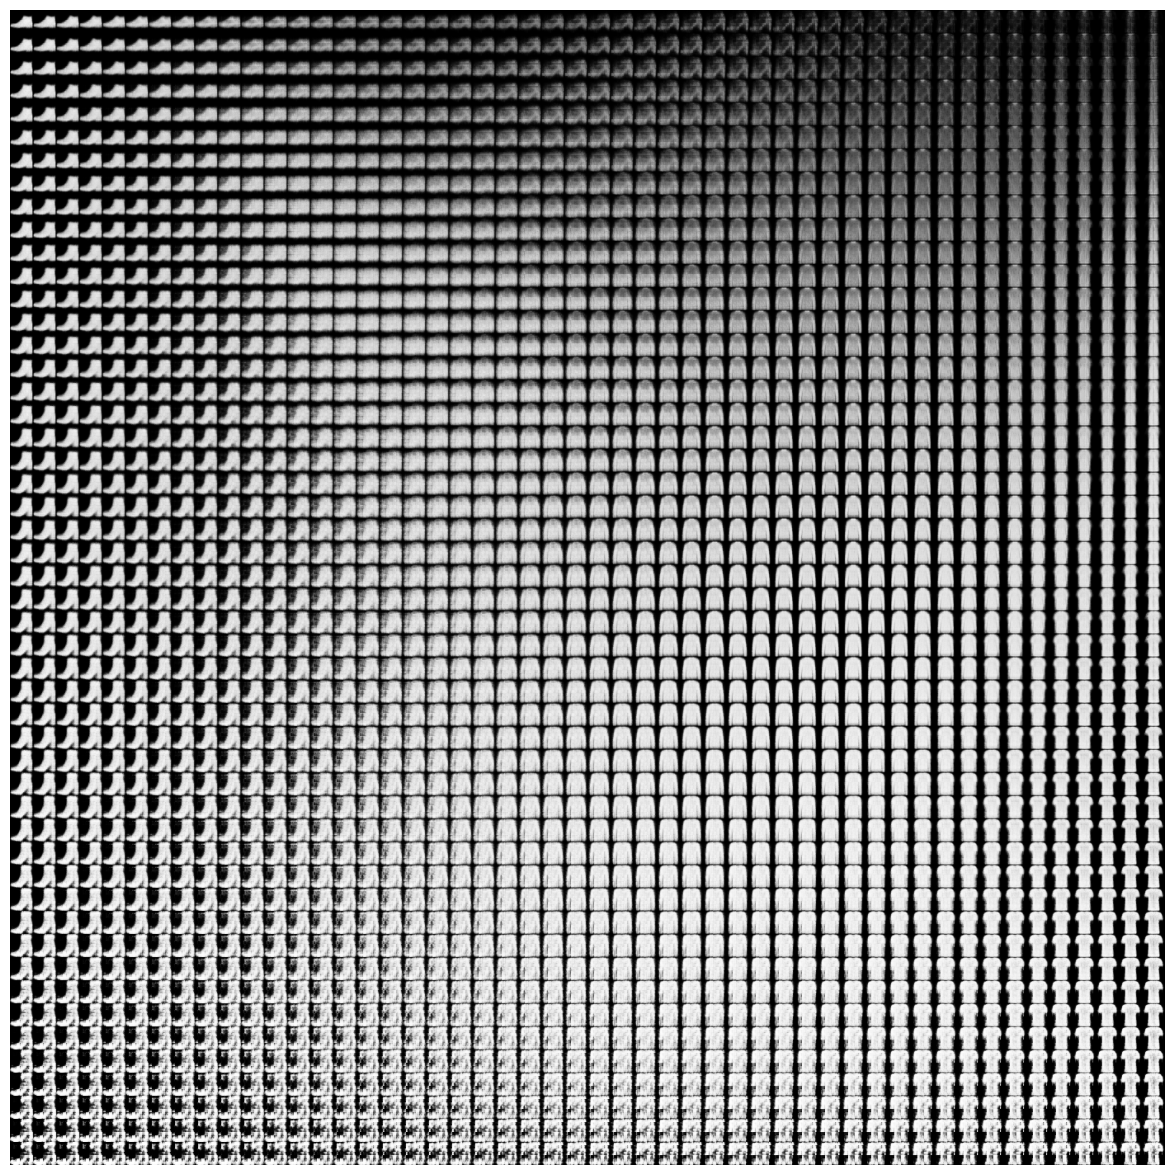

In [ ]:
def plot_latent_images(model, n, digit_size=28) :
    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.tensor(np.linspace(0.05, 0.95, n)))
    grid_y = norm.icdf(torch.tensor(np.linspace(0.05, 0.95, n)))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x) :
        for j, xi in enumerate(grid_y) :
            z = torch.Tensor([[xi, yi]])

            x_decoded = model.decoder(z)
            image[i * digit_size: (i+1)*digit_size,
                  j * digit_size: (j+1)*digit_size] = x_decoded.detach().numpy()

    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_latent_images(model, 50)

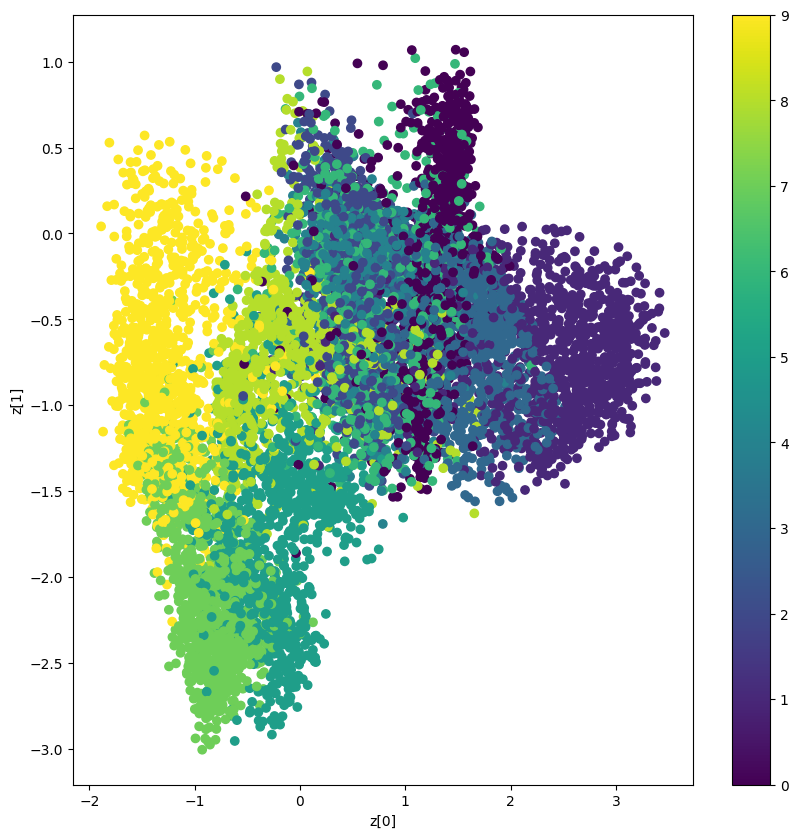

In [ ]:
def tsne_plot_results(model,
                 test_x,
                 test_y,
                 batch_size=128,
                 model_name="vae_mnist"):

    x = torch.Tensor(test_x)
    y = test_y
    os.makedirs(model_name, exist_ok=True)

    filename = "vae_mean.png"
    z_mean, _ = model.encoder(x)
    z_mean = z_mean.detach().numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

tsne_plot_results(model = model,
                 test_x = pre_test_dataset,
                 test_y = test_dataset.targets,
                 batch_size=128,
                 model_name="vae")